# Baseline logit on spectacle companies with statmodels

## Importation des packages et des données

In [1]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

import statsmodels.api as sm

import pickle
import warnings

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/musique"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [4]:
def features_target_split(dataset_train, dataset_test):
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [5]:
dataset_train, dataset_test = load_train_test()

/tmp/ipykernel_426/3642896088.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")
/tmp/ipykernel_426/3642896088.py:11: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_test = pd.read_csv(file_in, sep=",")


In [6]:
dataset_train.isna().sum()

customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              327067
mcp_contact_id            135224
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                354365
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date          119201
max_price                 119201
ticket_sum                     0
average_price             115193
average_purchase_delay    119203
average_price_basket      119203
average_ticket_basket     119203
total_price                 4008
purchase_count                 0
first_buying_date         119201
country   

In [7]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)

In [8]:
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (354365, 17)
Shape test :  (151874, 17)


## optionnel : calcul des poids
On pourrait utiliser les poids pour gérer le déséquilibre de classe, mais dans une optique exploratoire, c'est pas indispensable et ça a pas été utilisé ici !

In [9]:
# Compute Weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train['y_has_purchased']),
                                            y = y_train['y_has_purchased'])

weight_dict = {np.unique(y_train['y_has_purchased'])[i]: weights[i] for i in range(len(np.unique(y_train['y_has_purchased'])))}
weight_dict

{0.0: 0.5481283836040216, 1.0: 5.694439980716696}

In [10]:
# Calcul des poids inverses à la fréquence des classes
class_counts = np.bincount(y_train['y_has_purchased'])
class_weights = len(y_train['y_has_purchased']) / (2 * class_counts)

# Sélection des poids correspondants à chaque observation
weights = class_weights[y_train['y_has_purchased'].values.astype(int)]
weights

array([0.54812838, 0.54812838, 0.54812838, ..., 5.69443998, 0.54812838,
       0.54812838])

In [11]:
# verif
print(2 * weights * class_counts[y_train['y_has_purchased'].values.astype(int)])
print(len(y_train['y_has_purchased']))

[354365. 354365. 354365. ... 354365. 354365. 354365.]
354365


## définition des variables X et y

In [12]:
# visu de X_train
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
354360         0.0           0.0           0.0           0.0   
354361         0.0           0.0           0.0           0.0   
354362         2.0           2.0          50.0           1.0   
354363         1.0           1.0          55.0           1.0   
354364         0.0           0.0           0.0           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         550.000000         550.000000   
1                      0.0         550.000000         550.000000   
2                      0.0         550.000000         550.000000   
3                      0.0         550.000000         550.000000   
4                      0.0         550.000000         550.000000   
...                    ...                ...                ...   
354360                 0.0         550.000000         550.000000   
354361                 0.0         550.000000         550.000000   
354362                 0.0          91.030556          91.020139   
354363                 0.0          52.284028          52.284028   
354364                 0.0         550.000000         550.000000   

        time_between_purchase  nb_tickets_internet  fidelity  is_email_true  \
0                   -1.000000                  0.0         1           True   
1                   -1.000000                  0.0         0           True   
2                   -1.000000                  0.0         1           True   
3                   -1.000000                  0.0         0           True   
4                   -1.000000                  0.0         0           True   
...                       ...                  ...       ...            ...   
354360              -1.000000                  0.0         0           True   
354361              -1.000000                  0.0         0           True   
354362               0.010417                  0.0         4           True   
354363               0.000000                  0.0         1           True   
354364              -1.000000                  0.0         0           True   

        opt_in  gender_female  gender_male  gender_other  nb_campaigns  \
0         True              1            0             0          13.0   
1         True              0            0             1          10.0   
2         True              0            1             0          14.0   
3        False              0            0             1           9.0   
4        False              0            0             1           4.0   
...        ...            ...          ...           ...           ...   
354360   False              0            0             1           7.0   
354361    True              0            1             0          11.0   
354362   False              1            0             0           6.0   
354363    True              0            1             0           3.0   
354364   False              0            1             0           7.0   

        nb_campaigns_opened  
0                       4.0  
1                       9.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
354360                  0.0  
354361                  2.0  
354362                  6.0  
354363                  0.0  
354364                  0.0  

[354365 rows x 17 columns]

In [13]:
# model logit
X = X_train.astype(int)
# X = sm.add_constant(X.drop("gender_other", axis=1))
y = y_train['y_has_purchased'].values

# print(X,y)

In [14]:
X

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0                0             0             0             0   
1                0             0             0             0   
2                0             0             0             0   
3                0             0             0             0   
4                0             0             0             0   
...            ...           ...           ...           ...   
354360           0             0             0             0   
354361           0             0             0             0   
354362           2             2            50             1   
354363           1             1            55             1   
354364           0             0             0             0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                        0                550                550   
1                        0                550                550   
2                        0                550                550   
3                        0                550                550   
4                        0                550                550   
...                    ...                ...                ...   
354360                   0                550                550   
354361                   0                550                550   
354362                   0                 91                 91   
354363                   0                 52                 52   
354364                   0                550                550   

        time_between_purchase  nb_tickets_internet  fidelity  is_email_true  \
0                          -1                    0         1              1   
1                          -1                    0         0              1   
2                          -1                    0         1              1   
3                          -1                    0         0              1   
4                          -1                    0         0              1   
...                       ...                  ...       ...            ...   
354360                     -1                    0         0              1   
354361                     -1                    0         0              1   
354362                      0                    0         4              1   
354363                      0                    0         1              1   
354364                     -1                    0         0              1   

        opt_in  gender_female  gender_male  gender_other  nb_campaigns  \
0            1              1            0             0            13   
1            1              0            0             1            10   
2            1              0            1             0            14   
3            0              0            0             1             9   
4            0              0            0             1             4   
...        ...            ...          ...           ...           ...   
354360       0              0            0             1             7   
354361       1              0            1             0            11   
354362       0              1            0             0             6   
354363       1              0            1             0             3   
354364       0              0            1             0             7   

        nb_campaigns_opened  
0                         4  
1                         9  
2                         0  
3                         0  
4                         0  
...                     ...  
354360                    0  
354361                    2  
354362                    6  
354363                    0  
354364                    0  

[354365 rows x 17 columns]

In [138]:
X_train[["purchase_date_min", "purchase_date_max"]].describe()

purchase_date_min  purchase_date_max
count      354365.000000      354365.000000
mean          406.981861         396.551502
std           189.343612         195.881681
min             0.009640           0.000000
25%           188.475293         153.457966
50%           550.000000         550.000000
75%           550.000000         550.000000
max           550.000000         550.000000

In [143]:
(X_train["purchase_date_min"] - X_train["purchase_date_max"]).describe()

count    354365.000000
mean         10.430360
std          56.442718
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         547.443350
dtype: float64

In [145]:
X_train[X_train["time_between_purchase"]==-1]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
354358         0.0           0.0           0.0           0.0   
354359         0.0           0.0           0.0           0.0   
354360         0.0           0.0           0.0           0.0   
354361         0.0           0.0           0.0           0.0   
354364         0.0           0.0           0.0           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0              550.0              550.0   
1                      0.0              550.0              550.0   
2                      0.0              550.0              550.0   
3                      0.0              550.0              550.0   
4                      0.0              550.0              550.0   
...                    ...                ...                ...   
354358                 0.0              550.0              550.0   
354359                 0.0              550.0              550.0   
354360                 0.0              550.0              550.0   
354361                 0.0              550.0              550.0   
354364                 0.0              550.0              550.0   

        time_between_purchase  nb_tickets_internet  fidelity  is_email_true  \
0                        -1.0                  0.0         1           True   
1                        -1.0                  0.0         0           True   
2                        -1.0                  0.0         1           True   
3                        -1.0                  0.0         0           True   
4                        -1.0                  0.0         0           True   
...                       ...                  ...       ...            ...   
354358                   -1.0                  0.0         0           True   
354359                   -1.0                  0.0         0           True   
354360                   -1.0                  0.0         0           True   
354361                   -1.0                  0.0         0           True   
354364                   -1.0                  0.0         0           True   

        opt_in  gender_female  gender_male  gender_other  nb_campaigns  \
0         True              1            0             0          13.0   
1         True              0            0             1          10.0   
2         True              0            1             0          14.0   
3        False              0            0             1           9.0   
4        False              0            0             1           4.0   
...        ...            ...          ...           ...           ...   
354358   False              1            0             0           1.0   
354359    True              0            1             0          12.0   
354360   False              0            0             1           7.0   
354361    True              0            1             0          11.0   
354364   False              0            1             0           7.0   

        nb_campaigns_opened  
0                       4.0  
1                       9.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
354358                  0.0  
354359                  2.0  
354360                  0.0  
354361                  2.0  
354364                  0.0  

[179675 rows x 17 columns]

## Prétraitement des données + modèle

- variables à retirer : fidelity (valeurs trop grandes dont l'exp -> +inf, autre problème : st basé sur des infos qu'on a pas sur la période étudiée mais slt sur période d'évaluation), time between purchase (revoir sa construction), gender_other (colinéarité avec les autres var de genre)
- ajouter un intercept
- pas besoin de standardiser pour le moment, mais à faire quand on passera au modèle LASSO

#### A recopier dans la pipeline -> section 2 bis

In [15]:
# 0. on retire les variables citées ci-dessus et on ajoute l'intercept

X = sm.add_constant(X.drop(["fidelity", "time_between_purchase", "gender_other"], axis=1))
X

const  nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0         1.0           0             0             0             0   
1         1.0           0             0             0             0   
2         1.0           0             0             0             0   
3         1.0           0             0             0             0   
4         1.0           0             0             0             0   
...       ...         ...           ...           ...           ...   
354360    1.0           0             0             0             0   
354361    1.0           0             0             0             0   
354362    1.0           2             2            50             1   
354363    1.0           1             1            55             1   
354364    1.0           0             0             0             0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                        0                550                550   
1                        0                550                550   
2                        0                550                550   
3                        0                550                550   
4                        0                550                550   
...                    ...                ...                ...   
354360                   0                550                550   
354361                   0                550                550   
354362                   0                 91                 91   
354363                   0                 52                 52   
354364                   0                550                550   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                         0              1       1              1   
1                         0              1       1              0   
2                         0              1       1              0   
3                         0              1       0              0   
4                         0              1       0              0   
...                     ...            ...     ...            ...   
354360                    0              1       0              0   
354361                    0              1       1              0   
354362                    0              1       0              1   
354363                    0              1       1              0   
354364                    0              1       0              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 0            13                    4  
1                 0            10                    9  
2                 1            14                    0  
3                 0             9                    0  
4                 0             4                    0  
...             ...           ...                  ...  
354360            0             7                    0  
354361            1            11                    2  
354362            0             6                    6  
354363            1             3                    0  
354364            1             7                    0  

[354365 rows x 15 columns]

In [16]:
# 1. Premier modèle de régression logistique sans standardisation (permet une interprétation des coeffs)

model_logit = sm.Logit(y, X)

# Ajustement du modèle aux données
result = model_logit.fit()

# Affichage des résultats - toutes les var sont significatives avec des p-valeurs de 0, et de 0.28 pour nbre tickets
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.234602
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               354365
Model:                          Logit   Df Residuals:                   354350
Method:                           MLE   Df Model:                           14
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.2112
Time:                        07:57:46   Log-Likelihood:                -83135.
converged:                       True   LL-Null:                   -1.0540e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9633      0.093    -21.101      0.000      -2.146      -1.781
nb

In [17]:
# 2. Modèle logit avec données standardisées

# Colonnes à standardiser


var_num = ['nb_tickets', 'nb_purchases', "total_amount", "nb_suppliers", "vente_internet_max",
                          "purchase_date_min", "purchase_date_max", "nb_tickets_internet",
                          "nb_campaigns", "nb_campaigns_opened"]

# Standardisation des colonnes sélectionnées
scaler = StandardScaler()
X[var_num] = scaler.fit_transform(X[var_num])

In [18]:
X

const  nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0         1.0   -0.024425     -0.050722     -0.048383     -0.768294   
1         1.0   -0.024425     -0.050722     -0.048383     -0.768294   
2         1.0   -0.024425     -0.050722     -0.048383     -0.768294   
3         1.0   -0.024425     -0.050722     -0.048383     -0.768294   
4         1.0   -0.024425     -0.050722     -0.048383     -0.768294   
...       ...         ...           ...           ...           ...   
354360    1.0   -0.024425     -0.050722     -0.048383     -0.768294   
354361    1.0   -0.024425     -0.050722     -0.048383     -0.768294   
354362    1.0   -0.000838      0.092966     -0.009150      1.219633   
354363    1.0   -0.012631      0.021122     -0.005227      1.219633   
354364    1.0   -0.024425     -0.050722     -0.048383     -0.768294   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                -0.599511           0.755994           0.783940   
1                -0.599511           0.755994           0.783940   
2                -0.599511           0.755994           0.783940   
3                -0.599511           0.755994           0.783940   
4                -0.599511           0.755994           0.783940   
...                    ...                ...                ...   
354360           -0.599511           0.755994           0.783940   
354361           -0.599511           0.755994           0.783940   
354362           -0.599511          -1.665887          -1.557073   
354363           -0.599511          -1.871668          -1.755983   
354364           -0.599511           0.755994           0.783940   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                 -0.264693              1       1              1   
1                 -0.264693              1       1              0   
2                 -0.264693              1       1              0   
3                 -0.264693              1       0              0   
4                 -0.264693              1       0              0   
...                     ...            ...     ...            ...   
354360            -0.264693              1       0              0   
354361            -0.264693              1       1              0   
354362            -0.264693              1       0              1   
354363            -0.264693              1       1              0   
354364            -0.264693              1       0              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 0      0.607945             0.522567  
1                 0      0.306155             1.701843  
2                 1      0.708542            -0.420854  
3                 0      0.205558            -0.420854  
4                 0     -0.297426            -0.420854  
...             ...           ...                  ...  
354360            0      0.004365            -0.420854  
354361            1      0.406752             0.050856  
354362            0     -0.096232             0.994277  
354363            1     -0.398023            -0.420854  
354364            1      0.004365            -0.420854  

[354365 rows x 15 columns]

In [19]:
# 2. modele avec var standardisées (permet de mieux jauger l'importance réelle de chaque variable)

model_logit = sm.Logit(y, X)
# model_logit = sm.Logit(y, X)

# Ajustement du modèle aux données
result = model_logit.fit()

# Affichage des résultats
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.234602
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               354365
Model:                          Logit   Df Residuals:                   354350
Method:                           MLE   Df Model:                           14
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.2112
Time:                        07:58:13   Log-Likelihood:                -83135.
converged:                       True   LL-Null:                   -1.0540e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.6025      0.091    -39.755      0.000      -3.780      -3.425
nb

In [48]:
# 2.bis on fait de même pour un modèle logit avec pénalité 
# pas besoin de redefinir le modèle, il faut faire un fit_regularized

# sans spécification, le alpha optimal est déterminé par cross validation
# remplacer alpha=32 par la valeur optimale trouvée par cross validation dans la pipeline avec .best_params
# attention, dans scikit learn, l'hyperparamètre est C = 1/alpha, pas oublier de prendre l'inverse de ce C optimal

result = model_logit.fit_regularized(method='l1', alpha = 32)

print(result.pvalues)
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23562928627877766
            Iterations: 240
            Function evaluations: 243
            Gradient evaluations: 240
const                   0.000000e+00
nb_tickets              2.477006e-01
nb_purchases            1.636902e-03
total_amount            8.839088e-04
nb_suppliers            1.906550e-65
vente_internet_max      0.000000e+00
purchase_date_min       0.000000e+00
purchase_date_max       0.000000e+00
nb_tickets_internet    7.232680e-112
is_email_true           8.202187e-08
opt_in                  0.000000e+00
gender_female          1.624424e-170
gender_male            4.961315e-220
nb_campaigns           6.276733e-205
nb_campaigns_opened    2.228531e-176
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               354365
Model:                          Logit   Df Residuals:     

### Other method : take into account the weigths ! Pb : with this method, no penalty allowed

In [247]:
# define a function to generate summaries of logit model

def model_logit(X, y, weight_dict, add_constant=False) :
    # Generate sample weights based on class weights computed earlier
    sample_weights = np.array([weight_dict[class_] for class_ in y])

    if add_constant :
        X_const = sm.add_constant(X)
    else :
        X_const = X
   
    # Use GLM from statsmodels with Binomial family for logistic regression
    model = sm.GLM(y, X_const, family=sm.families.Binomial(), freq_weights=sample_weights)
    
    # fit without penalty
    result = model.fit()

    result_summary = result.summary()
    
    return result_summary

In [248]:
# with the function

# 1. logit with weights
results_logit_weight = model_logit(X,y,weight_dict=weight_dict)
print(results_logit_weight)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               354365
Model:                            GLM   Df Residuals:                   354350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8693e+05
Date:                Thu, 21 Mar 2024   Deviance:                   3.7387e+05
Time:                        13:19:33   Pearson chi2:                 1.97e+16
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2820
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3943    

In [252]:
# 2. logit without weights

results_logit = model_logit(X.drop("const", axis=1),y,weight_dict={0:1, 1:1}, add_constant=True)
print(results_logit)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               354365
Model:                            GLM   Df Residuals:                   354350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83141.
Date:                Thu, 21 Mar 2024   Deviance:                   1.6628e+05
Time:                        13:20:06   Pearson chi2:                 4.52e+15
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1180
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.6025    

## graphique LASSO - quelles variables sont importantes dans le modèle ? 

In [313]:
# difference entre les solveurs (les resultats de statsmodel s'approchent de newtown cholesky)

for solver in ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"] :
    modele_logit = LogisticRegression(penalty=None, solver=solver)
    modele_logit.fit(X.drop("const", axis=1), y)
    print(f"results for solver {solver}")
    print(f"intercept : {modele_logit.intercept_[0]}")
    print(f"coefficients : {modele_logit.coef_}")
    print("\n")

results for solver lbfgs
intercept : -3.617357317895187
coefficients : [[-0.03114285 -0.06607353  0.10099873  0.16977395 -0.87625108  0.58870838
  -1.42022841  0.28837776  0.87461022 -2.00037064  0.70874574  0.8136523
   0.2850802   0.20640785]]


results for solver newton-cg
intercept : -3.5774790840156467
coefficients : [[-0.0224498  -0.05092757  0.07842438  0.16941048 -0.87645255  0.58801191
  -1.41953483  0.28961165  0.84037075 -1.99757163  0.70302619  0.8068438
   0.2849652   0.20613618]]


results for solver newton-cholesky
intercept : -3.602198310216717
coefficients : [[-0.02297134 -0.05187501  0.07986323  0.1693883  -0.87639043  0.58815512
  -1.41963236  0.28949836  0.86505556 -1.99695897  0.70307973  0.80688729
   0.2849131   0.20610117]]




/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


results for solver sag
intercept : -1.251116606796448
coefficients : [[-0.02952178 -0.05691972  0.08940743  0.18616406 -0.85908081  0.46577384
  -1.26014292  0.32512459 -1.00339802 -1.84528471  0.15832219  0.24753693
   0.26318328  0.21288782]]


results for solver saga
intercept : -1.112341737293756
coefficients : [[-0.03349226 -0.02298918  0.09611619  0.23784438 -0.80928967  0.28520739
  -1.01029862  0.30172469 -0.99503611 -1.53140972 -0.04449765  0.02363137
   0.20352875  0.22580284]]




/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


on passe au graphique


In [449]:
# il faut environ alpha = 25k pour annuler tous les coeffs
# on utilise pas de balance pour les classes pour le moment car les résultats de statsmodels n equilibrent 
# pas les classes - on utilisera cette option pr la validation croisee

modele_logit = LogisticRegression(penalty="l1", C=1/25000, # class_weight="balanced", 
                                      solver="liblinear" )
modele_logit.fit(X.drop("const", axis=1),y)
modele_logit.coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [370]:
params = np.logspace(-5, 5, 11, 10)

In [371]:
results=[]
for param in params :
    modele_logit = LogisticRegression(penalty="l1", C=param, # class_weight="balanced", 
                                      solver="liblinear" )
    modele_logit.fit(X.drop("const", axis=1),y)
    results.append(modele_logit.coef_)

In [383]:
results.reverse()

In [384]:
results

[array([[-0.02299412, -0.05192013,  0.0799274 ,  0.16931227, -0.87633381,
          0.58813399, -1.41967385,  0.28951886,  0.85509191, -1.99754475,
          0.70287087,  0.80669243,  0.28498239,  0.2061286 ]]),
 array([[-0.02299201, -0.05191491,  0.07992075,  0.16931139, -0.87634243,
          0.58813708, -1.41968623,  0.28952223,  0.85577021, -1.99756453,
          0.70288563,  0.80669012,  0.28498258,  0.20612949]]),
 array([[-0.02299764, -0.05192605,  0.07993569,  0.16930528, -0.87632586,
          0.58811345, -1.41964512,  0.28952983,  0.85374762, -1.99754811,
          0.70282334,  0.80664228,  0.28498228,  0.20613025]]),
 array([[-0.02298949, -0.05191449,  0.07991828,  0.16931317, -0.87634417,
          0.58812319, -1.4196808 ,  0.2895181 ,  0.85546622, -1.99754003,
          0.70302758,  0.80684757,  0.28498265,  0.20613162]]),
 array([[-0.02296458, -0.05187503,  0.07985942,  0.16928133, -0.87628414,
          0.5880753 , -1.41959837,  0.28951824,  0.85207105, -1.99743532,
    

In [392]:
# le paramètre C est l'inverse de alpha. On préfère donc afficher les valeurs de alpha qui sont plus parlantes
# un alpha grand correspond à une plus grande pénalité 
# et on utilise flip pour inverser le vecteur, et classer les alphas par ordre croissant
# par souci de coherence et de lisibilité, on inverse donc aussi l'ordre des resultats

alphas_sorted = np.flip(1/params)
alphas_sorted

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [447]:
X_colnames = X.drop("const", axis=1).columns
X_colnames

Index(['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers',
       'vente_internet_max', 'purchase_date_min', 'purchase_date_max',
       'nb_tickets_internet', 'is_email_true', 'opt_in', 'gender_female',
       'gender_male', 'nb_campaigns', 'nb_campaigns_opened'],
      dtype='object')

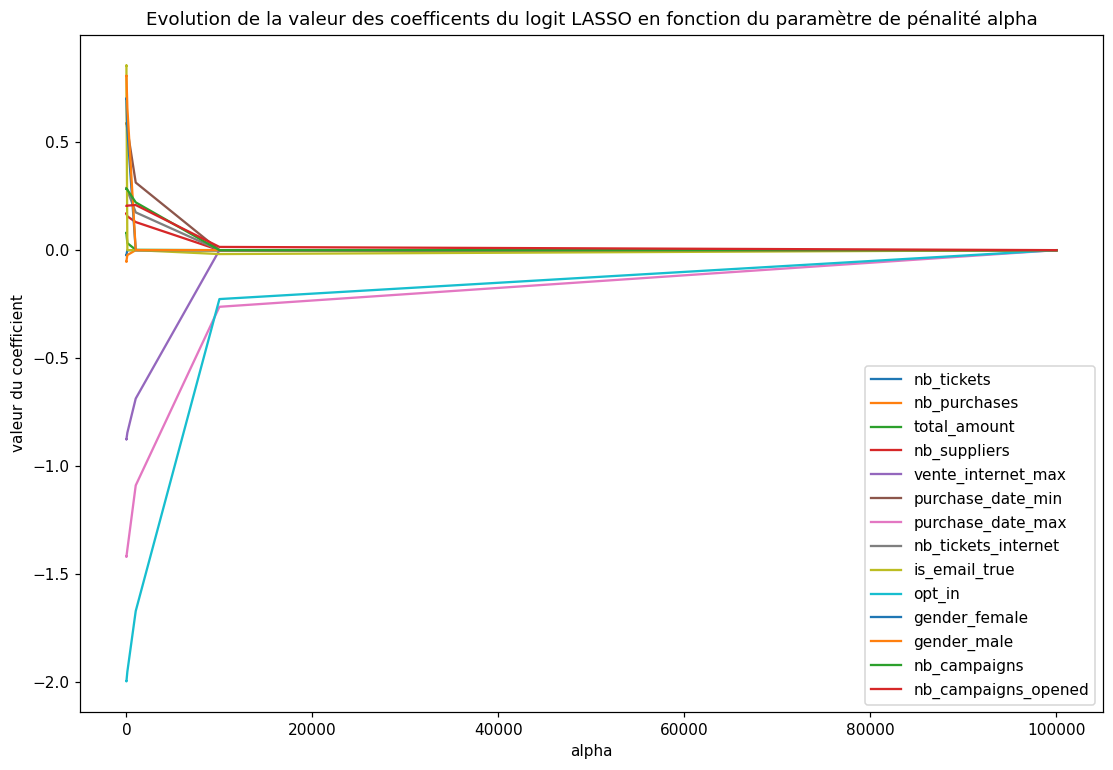

In [448]:
# graphique

plt.figure(figsize=[12,8], dpi=110)

for i in range(len(X_colnames)) :
    var_name = X_colnames[i]
    plt.plot(alphas_sorted, [results[p][0][i] for p in range(len(results))], label = var_name)

plt.legend()
plt.title("Evolution de la valeur des coefficents du logit LASSO en fonction du paramètre de pénalité alpha")
plt.xlabel("alpha")
plt.ylabel("valeur du coefficient")
plt.show()

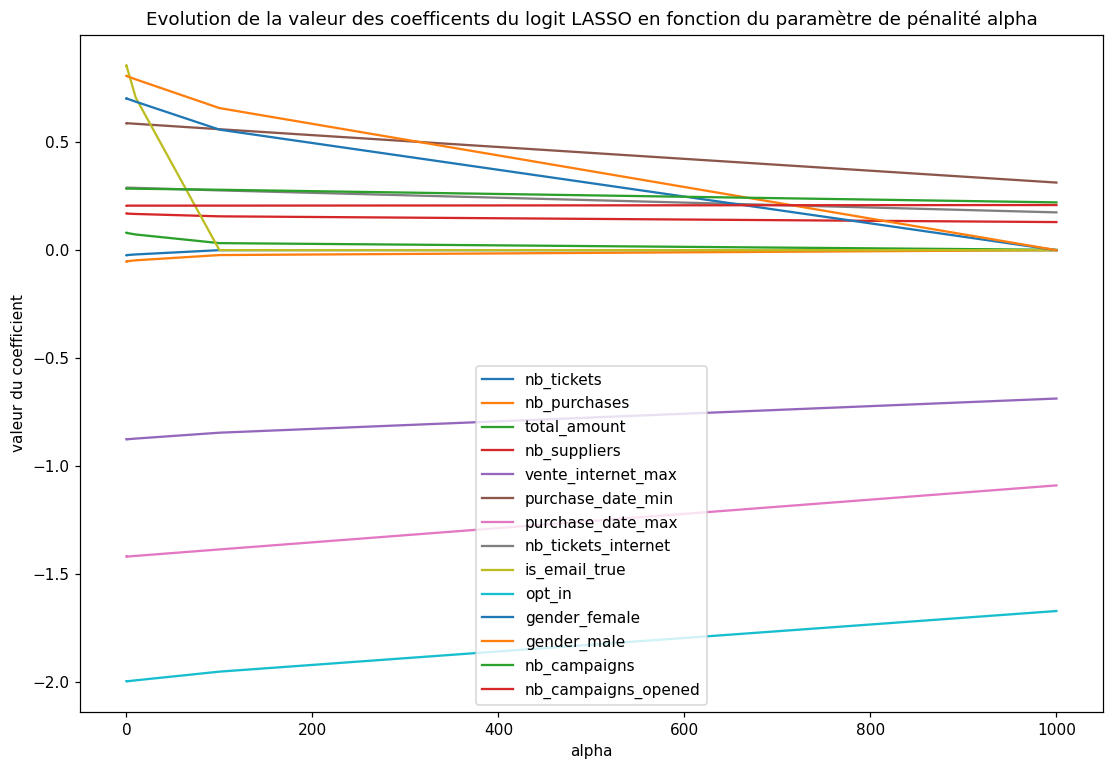

In [444]:
# hide right part of the graphic
# some coefficients are still strictly positive even for alpha =10k, which makes the graphic quite confusing
# alternative syntax

endpoint = 9

fig, ax = plt.subplots(figsize=[12,8], dpi=110)

for i in range(len(X_colnames)) :
    var_name = X_colnames[i]
    ax.plot(alphas_sorted[:endpoint], [results[p][0][i] for p in range(len(results[:endpoint]))], label=var_name)
    
ax.set(xlabel="alpha",
       ylabel="valeur du coefficient",
      title = "Evolution de la valeur des coefficents du logit LASSO en fonction du paramètre de pénalité alpha")
ax.legend()
plt.show()

A retenir : \
D'après le premier tableau de résultats, toutes les variables sont significatives au seuil de 5%, et à l'exception de nb tickets, elles sont même significatives à 0.1%. \
Le graphique ci-dessus confirme que opt in, purchase date max, ventes internet max sont très importantes dans le modèle (on l'avait déjà remarqué car les valeurs des coefficients étaient élevées). \
Au contraire, des variables qui avaient un fort coefficient comme is email true (0.87) se trouvent finalement fortement pénalisées et tombent plus vite à 0 que les autres. 